- Suppose that we have a company that selling some of the product, and you want to know how well does the selling performance of the product.
- Well, we can segment customers based on their buying behavior on the market.

- Plan of attack
    - Gather the data
    - Create Recency Frequency Monetary (RFM) table
    - Manage skewness and scale each variable
    - Explore the data
    - Cluster the data
    - Interpret the result

1. Gathering of data

In [1]:
# Importing the libraries

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

- Got the data from UCI Machine Learning called Online Retail dataset.

In [2]:
# Importing the data
df = pd.read_excel('Desktop/customer_segmentation/Online Retail.xlsx', parse_dates=['InvoiceDate'])

df = df[df['CustomerID'].notna()]
# notna() function detects existing/ non-missing values in the dataframe. The function returns
# a boolean object having the same size as that of the object on which it is applied, indicating
# whether each individual value is a na value or not.

In [3]:
df.shape

(406829, 8)

In [4]:
#sample the dataset
# Pandas sample() is used to generate a sample random row or column from the function caller data frame.
df_fix = df.sample(10000, random_state = 42)
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom


1. To make RFM table, we can create columns such as Recency, Frequency and MonetaryValue column

2. Create Recency Frequency Monetary (RFM) table
    - Recency - when the customer buy the product for last time
        - To find it, subtract the snapshot date with the date where the transaction occurred.
    - Frequency - how frequent the customer buy the product
        - To make column, we can count how much transactions by each customer
    - MonetaryValue - how much the customer pays for the product
        - to create the monetary value column, we can sum all transactions for each customer.

In [5]:
#from datetime import datetime

In [6]:
df_fix['InvoiceDate'].max()

Timestamp('2011-12-09 12:16:00')

In [7]:
df_fix['InvoiceDate']

47912    2011-01-07 12:14:00
342630   2011-09-15 13:51:00
288183   2011-08-03 10:10:00
325368   2011-09-04 13:56:00
331450   2011-09-08 12:20:00
                 ...        
123      2010-12-01 09:41:00
449041   2011-11-08 13:30:00
425967   2011-10-30 11:55:00
70029    2011-01-25 10:38:00
282657   2011-07-28 15:55:00
Name: InvoiceDate, Length: 10000, dtype: datetime64[ns]

In [8]:
#convert to show date only
from datetime import datetime
df_fix['InvoiceDate'] = df_fix['InvoiceDate'].dt.date


In [9]:
#create totalsum column
df_fix['TotalSum'] = df_fix['Quantity']*df_fix['UnitPrice']

In [10]:
#create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

In [11]:
#aggregate data from each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

In [12]:
#Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'},
                inplace=True)

In [13]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30


In [14]:
customers['Recency'].head()

CustomerID
12347.0     40
12348.0    249
12349.0     19
12352.0     73
12354.0    233
Name: Recency, dtype: int64

In [15]:
customers['Recency'].median()

72.0

In [16]:
customers.median()

Recency          72.0
Frequency         2.0
MonetaryValue    30.0
dtype: float64

In [17]:
customers.mean()

Recency          110.934201
Frequency          3.717472
MonetaryValue     73.625743
dtype: float64

In [18]:
customers['Recency'].value_counts()

5      46
4      43
2      37
18     37
3      36
       ..
211     1
215     1
362     1
223     1
272     1
Name: Recency, Length: 301, dtype: int64

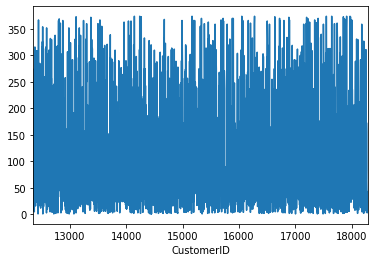

In [19]:
customers['Recency'].plot()

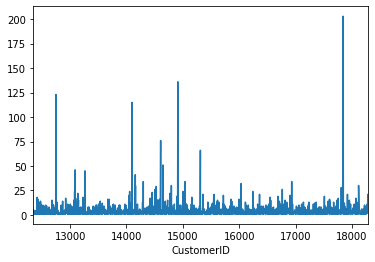

In [20]:
customers['Frequency'].plot()

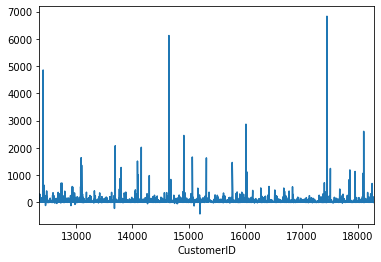

In [21]:
customers['MonetaryValue'].plot()

- For handling skewness, we will we will utilize variables that use box-cox transformations. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data

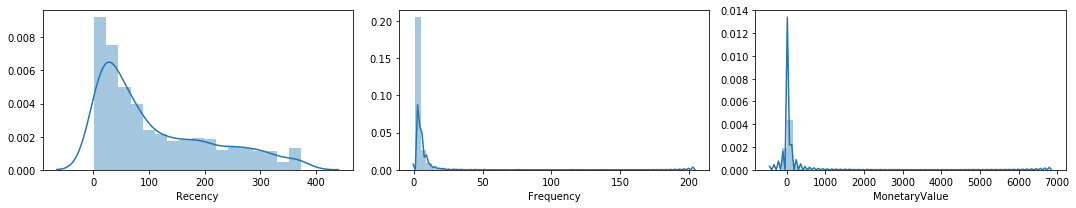

In [37]:
import seaborn as sns
fig, ax=plt.subplots(1,3,figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [38]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

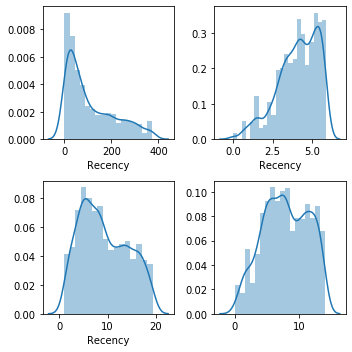

0.93
-0.72
0.32
-0.1


In [39]:
analyze_skewness('Recency')

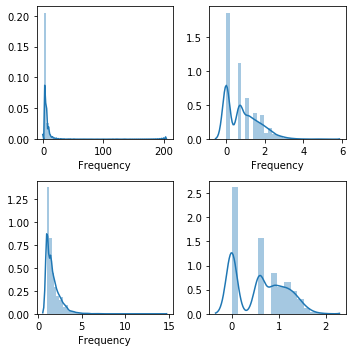

14.77
0.85
3.67
0.16


In [44]:
analyze_skewness('Frequency')

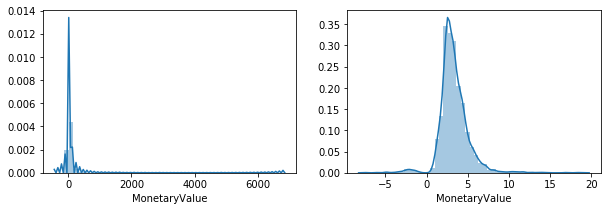

16.63
1.16


In [46]:
from scipy import stats
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [47]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [48]:
#set the numbers
customers_fix=pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"]=stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"]=pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


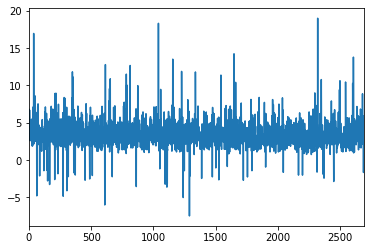

In [23]:
customers_fix['MonetaryValue'].plot()

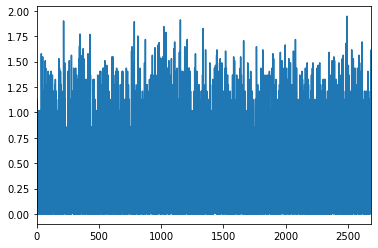

In [24]:
customers_fix['Frequency'].plot()

In [25]:
from sklearn.preprocessing import StandardScaler

#Initiaize the Object
scaler = StandardScaler()

#Fit and transform the data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

#assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis=0).round(2))
print(customers_normalized.std(axis=0).round(2))


[ 0. -0.  0.]
[1. 1. 1.]


In [36]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.493794,1.012426,1.017503
1,1.232949,-0.017412,0.925115
2,-0.994917,-0.017412,1.972690
3,-0.012582,1.012426,0.572565
4,1.155005,-0.017412,-0.056441


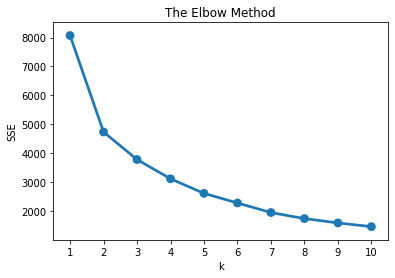

In [27]:
from sklearn.cluster import KMeans
import seaborn as sns
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest centroid
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Fitting the model now

In [28]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [49]:
customers.shape

(2690, 4)

We can summarize the RFM table based on clusters and calculate the mean of each variable. The code will look like this,

In [29]:
customers["Cluster"]=model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         46.25      7.71        165.79   924
1         47.62      1.61         21.51   811
2        227.29      1.64         28.70   955

interpretation with snake plot


In [51]:
# creaate the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency','MonetaryValue'])
df_normalized['ID']=customers.index
df_normalized['Cluster']=model.labels_
df_normalized.head()




,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.493794,1.012426,1.017503,12347.0,0
1,1.232949,-0.017412,0.925115,12348.0,2
2,-0.994917,-0.017412,1.972690,12349.0,0
3,-0.012582,1.012426,0.572565,12352.0,0
4,1.155005,-0.017412,-0.056441,12354.0,2


In [52]:
#Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                     id_vars=['ID','Cluster'],
                     value_vars=['Recency','Frequency','MonetaryValue'],var_name='Attribute',value_name='Value')
df_nor_melt

,ID,Cluster,Attribute,Value
0,12347.0,0,Recency,-0.493794
1,12348.0,2,Recency,1.232949
2,12349.0,0,Recency,-0.994917
3,12352.0,0,Recency,-0.012582
4,12354.0,2,Recency,1.155005
...,...,...,...,...
8065,18265.0,1,MonetaryValue,0.052265
8066,18272.0,0,MonetaryValue,1.472436
8067,18274.0,1,MonetaryValue,-2.833266
8068,18283.0,0,MonetaryValue,0.543657


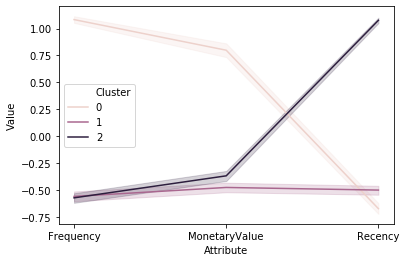

In [33]:
#visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)